In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from numba import jit
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error,r2_score
from explainerdashboard import RegressionExplainer, ExplainerDashboard
import seaborn as sns

In [61]:
data = pd.read_excel("Final_Data.xlsx")

In [62]:
df = data.copy()

In [63]:
df.shape

(356245, 15)

In [64]:
df = df.head(5000)

In [65]:
df.shape

(5000, 15)

In [66]:
df.drop(["model","description","lat","long","posting_date"],axis=1,inplace = True)

In [67]:
df.head()

,region,price,year,manufacturer,fuel,odometer,title_status,transmission,type,state
0,auburn,33590,2014.0,gmc,gas,57923.0,clean,other,pickup,al
1,auburn,22590,2010.0,chevrolet,gas,71229.0,clean,other,pickup,al
2,auburn,39590,2020.0,chevrolet,gas,19160.0,clean,other,pickup,al
3,auburn,30990,2017.0,toyota,gas,41124.0,clean,other,pickup,al
4,auburn,15000,2013.0,ford,gas,128000.0,clean,automatic,truck,al


In [68]:
df['manufacturer'].unique()

array(['gmc', 'chevrolet', 'toyota', 'ford', 'jeep', 'nissan', 'ram',
       'mazda', 'cadillac', 'honda', 'dodge', 'lexus', 'jaguar', 'buick',
       'chrysler', 'volvo', 'audi', 'infiniti', 'lincoln', 'alfa-romeo',
       'subaru', 'acura', 'hyundai', 'mercedes-benz', 'bmw', 'mitsubishi',
       'volkswagen', 'porsche', 'kia', 'mini', 'pontiac', 'fiat', 'rover',
       'tesla', 'mercury', 'saturn'], dtype=object)

In [69]:
df['fuel'].unique()

array(['gas', 'other', 'diesel', 'hybrid', 'electric'], dtype=object)

In [70]:
df['title_status'].unique()

array(['clean', 'rebuilt', 'lien', 'salvage', 'missing', 'parts only'],
      dtype=object)

In [71]:
df['transmission'].unique()

array(['other', 'automatic', 'manual'], dtype=object)

In [72]:
df['type'].unique()

array(['pickup', 'truck', 'other', 'sedan', 'coupe', 'SUV', 'hatchback',
       'mini-van', 'offroad', 'convertible', 'wagon', 'van', 'bus'],
      dtype=object)

In [73]:
df['state'].unique()

array(['al', 'ak'], dtype=object)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        5000 non-null   object 
 1   price         5000 non-null   int64  
 2   year          5000 non-null   float64
 3   manufacturer  5000 non-null   object 
 4   fuel          5000 non-null   object 
 5   odometer      5000 non-null   float64
 6   title_status  5000 non-null   object 
 7   transmission  5000 non-null   object 
 8   type          5000 non-null   object 
 9   state         5000 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 390.8+ KB


In [75]:
from sklearn.preprocessing import LabelEncoder

region_encoder = LabelEncoder()
df['region'] = region_encoder.fit_transform(df['region'])

manufacturer_encoder = LabelEncoder()
df["manufacturer"] = manufacturer_encoder.fit_transform(df["manufacturer"])

fuel_encoder = LabelEncoder()
df["fuel"] = fuel_encoder.fit_transform(df["fuel"])

title_encoder = LabelEncoder()
df["title_status"] = title_encoder.fit_transform(df["title_status"])

transmission_encoder = LabelEncoder()
df["transmission"] = transmission_encoder.fit_transform(df["transmission"])

type_encoder = LabelEncoder()
df["type"] = type_encoder.fit_transform(df["type"])

state_encoder = LabelEncoder()
df["state"] = state_encoder.fit_transform(df["state"])

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        5000 non-null   int32  
 1   price         5000 non-null   int64  
 2   year          5000 non-null   float64
 3   manufacturer  5000 non-null   int32  
 4   fuel          5000 non-null   int32  
 5   odometer      5000 non-null   float64
 6   title_status  5000 non-null   int32  
 7   transmission  5000 non-null   int32  
 8   type          5000 non-null   int32  
 9   state         5000 non-null   int32  
dtypes: float64(2), int32(7), int64(1)
memory usage: 254.0 KB


**Effect of Covid on car resale price**

In [80]:
pre_covid = df.loc[(df['year']>2017.0) & (df['year']<=2019.0)]
post_covid = df.loc[df['year']>2019.0]

In [81]:
pre_covid['year'].unique()

array([2019., 2018.])

In [82]:
post_covid['year'].unique()

array([2020., 2021.])

In [83]:
pre_covid['price'].mean()

29416.248798076922

In [84]:
post_covid['price'].mean()

34842.26345609065

Comparing the average car resale price for two years before and after COVID, it can be clearly seen that it is significantly high after COVID

**Keeping data of the only the years 2010 to 2021**

In [85]:
df.drop(df.index[df['year']<2010.0],inplace = True)
df.drop(df.index[df['year']>=2021.0],inplace = True)

<AxesSubplot:xlabel='year', ylabel='price'>

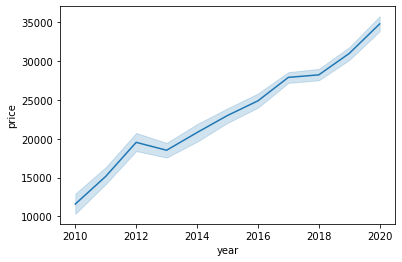

In [86]:
sns.lineplot(data = df, x = 'year', y='price')

In [87]:
X = df.drop(columns = ['price','title_status'])
y = df['price']

In [88]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 42)

In [89]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [90]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators= 600,max_depth= 80)
model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_test)

In [91]:
mean_absolute_percentage_error(y_test, y_pred)

0.21097800108109246

In [92]:
mean_squared_error(y_test, y_pred, squared=False)

5844.812026866556

In [93]:
r2_score(y_test, y_pred)

0.701787162969947